<a href="https://colab.research.google.com/github/vishalkapade986/Grammar-Scoring-Engine/blob/main/SHL_ASSESSMENT_VBK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



"""
# SHL Hiring Assessment
# Grammar Scoring Engine

**candidate**: Vishal Kapade  
**Date**: 07/04/2025


## Project Overview
This notebook develops an optimized Support Vector Machine (SVM) model to predict grammar proficiency scores from acoustic and prosodic features of speech recordings. The solution includes:

1. Data preprocessing pipeline
2. Feature selection
3. Hyperparameter optimization
4. Model evaluation
5. Results interpretation

## Evaluation Metrics
- Primary: Pearson Correlation Coefficient
- Secondary: Root Mean Squared Error (RMSE)
"""


In [ ]:
# ====================
# 1. Environment Setup
# ====================
!pip install librosa soundfile xgboost language-tool-python textstat spacy whisper webrtcvad kaggle
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 693.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.1 MB/s eta 0:00:00
  Created wheel for whisper: filename=whisper-1.1.10-py3-none-any.whl size=41120 sha256=116bd059425ddc2c73f4b8fe3ef221b79e9d566f33e2a908aa7cd147a616fb2a
  Stored in directory: /root/.cache/pip/wheels/21/65/ee/4e6672aabfa486d3341a39a04f8f87c77e5156149299b5a7d0
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp311-cp311-linux_x86_64.whl size=73497 sha

In [ ]:
# ====================
# 2. Data Preparation
# ====================
import os
import numpy as np
import pandas as pd

In [ ]:
# Configure Kaggle API
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json


In [ ]:
# Download dataset
!kaggle competitions download -c shl-intern-hiring-assessment
!unzip -q shl-intern-hiring-assessment.zip -d data


 99% 1.09G/1.10G [00:11<00:00, 148MB/s]
100% 1.10G/1.10G [00:11<00:00, 99.2MB/s]


In [ ]:
# Path configuration
TRAIN_AUDIO_DIR = "/content/data/dataset/audios_train"
TEST_AUDIO_DIR = "/content/data/dataset/audios_test"
TRAIN_CSV = "/content/data/dataset/train.csv"
TEST_CSV = "/content/data/dataset/test.csv"


In [ ]:
# Load metadata
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)


In [ ]:
!pip uninstall whisper -y  # Uninstall the current whisper package
!pip install git+https://github.com/openai/whisper.git # Install whisper from GitHub
import whisper

Found existing installation: whisper 1.1.10
Uninstalling whisper-1.1.10:
  Successfully uninstalled whisper-1.1.10
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-s3vddcd9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-s3vddcd9
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.

In [ ]:
# ========================
# 3. Feature Engineering
# ========================
import librosa
import webrtcvad
import spacy
import textstat
import whisper
from tqdm import tqdm
import language_tool_python # Import the language_tool_python module

# Initialize NLP tools
nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en-US')
asr_model = whisper.load_model("base")


INFO:language_tool_python.download_lt:Unzipping /tmp/tmp9wtnpkau.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.5.zip to /root/.cache/language_tool_python.
100%|███████████████████████████████████████| 139M/139M [00:03<00:00, 48.2MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

In [ ]:
# %% [markdown]
# ## 3. Audio Processing Module

# %%
class AudioProcessor:
    def __init__(self, target_duration=60, sr=16000):
        self.target_duration = target_duration
        self.sr = sr
        self.vad = webrtcvad.Vad(3)

    def _standardize_duration(self, y):
        target_samples = self.sr * self.target_duration
        current_samples = len(y)

        if current_samples < target_samples:
            padding = target_samples - current_samples
            y = np.pad(y, (0, padding), mode='constant')
        elif current_samples > target_samples:
            start = (current_samples - target_samples) // 2
            y = y[start:start+target_samples]
        return y

    def process_audio(self, audio_path):
        try:
            y, _ = librosa.load(audio_path, sr=self.sr, mono=True, res_type='kaiser_fast')
            y = self._standardize_duration(y)

            # Extract features
            features = {
                'original_duration': len(y) / self.sr,
                'sample_rate': self.sr
            }

            # MFCC Features
            mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=13)
            for i in range(13):
                features[f'mfcc_{i}_mean'] = np.nan_to_num(np.mean(mfcc[i]))
                features[f'mfcc_{i}_std'] = np.nan_to_num(np.std(mfcc[i]))

            # Pitch Analysis
            pitches = librosa.yin(y, fmin=80, fmax=400)
            valid_pitches = pitches[~np.isnan(pitches)]
            features.update({
                'pitch_mean': np.mean(valid_pitches) if valid_pitches.size > 0 else 0,
                'pitch_std': np.std(valid_pitches) if valid_pitches.size > 0 else 0
            })

            # Voice Activity Detection
            frame_len = int(self.sr * 0.01)  # 10ms frames
            y_int16 = (y * 32767).astype(np.int16)
            n_frames = len(y_int16) // frame_len
            frames = y_int16[:n_frames*frame_len].reshape(n_frames, frame_len)
            speech_frames = sum(self.vad.is_speech(f.tobytes(), self.sr) for f in frames)
            features.update({
                'speech_ratio': speech_frames / n_frames,
                'total_frames': n_frames
            })

            return features

        except Exception as e:
            print(f"Error processing {os.path.basename(audio_path)}: {str(e)[:50]}")
            return None


In [ ]:
# %% [markdown]
# ## 4. Text Processing Module

# %%
class TextAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.tool = language_tool_python.LanguageTool('en-US')
        self.asr = whisper.load_model("base")

    def analyze(self, audio_path):
        try:
            # Speech-to-Text
            result = self.asr.transcribe(audio_path)
            text = result['text'].strip()

            if not text:
                return {'text_length': 0, 'grammar_errors': 0}

            # Grammar Analysis
            matches = self.tool.check(text)

            # Readability Metrics
            features = {
                'text_length': len(text.split()),
                'grammar_errors': len(matches),
                'flesch_score': textstat.flesch_reading_ease(text),
                'fk_grade': textstat.flesch_kincaid_grade(text)
            }

            # POS Analysis
            doc = self.nlp(text)
            pos_counts = {'NOUN': 0, 'VERB': 0, 'ADJ': 0, 'ADV': 0}
            for token in doc:
                if token.pos_ in pos_counts:
                    pos_counts[token.pos_] += 1
            total = max(len(doc), 1)
            features.update({f'pos_{k.lower()}': count/total for k, count in pos_counts.items()})

            return features

        except Exception as e:
            print(f"Text analysis failed: {str(e)[:50]}")
            return None


In [ ]:
# %% [markdown]
# ## 5. Complete Processing Pipeline

# %%
def process_dataset(df, audio_dir, is_train=True):
    audio_processor = AudioProcessor()
    text_analyzer = TextAnalyzer()
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        audio_path = os.path.join(audio_dir, row['filename'])

        # Process audio
        audio_feats = audio_processor.process_audio(audio_path)
        if not audio_feats:
            continue

        # Process text
        text_feats = text_analyzer.analyze(audio_path)
        if not text_feats:
            continue

        # Combine features
        combined = {**audio_feats, **text_feats}
        if is_train:
            combined['label'] = row['label']
        combined['filename'] = row['filename']

        results.append(combined)

    return pd.DataFrame(results)


In [ ]:
# Process training data
print("Processing training set...")
train_features = process_dataset(train_df, TRAIN_AUDIO_DIR)
train_features.to_csv('train_features.csv', index=False)


Processing training set...


100%|██████████| 444/444 [44:37<00:00,  6.03s/it]


In [ ]:
# Process test data
print("\nProcessing test set...")
test_features = process_dataset(test_df, TEST_AUDIO_DIR, is_train=False)
test_features.to_csv('test_features.csv', index=False)



Processing test set...


/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
100%|████████

"""
## 4. Model Pipeline Architecture

The processing pipeline consists of:
1. **Imputation**: Median imputation for missing values
2. **Scaling**: Standardization (mean=0, std=1)
3. **Feature Selection**: SelectKBest with F-regression
4. **SVM Regression**: RBF kernel SVM with optimized parameters
"""

In [ ]:

# %%
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import pearsonr, randint, uniform
import joblib

# Load processed data
train_data = pd.read_csv('train_features.csv')
test_data = pd.read_csv('test_features.csv')

# Prepare data
X = train_data.drop(columns=['label', 'filename'])
y = train_data['label']

# Custom scorer for Pearson correlation
def pearson_scorer(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

pearson_score = make_scorer(pearson_scorer, greater_is_better=True)

# Enhanced pipeline with feature selection
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # More robust than mean
    ('scaler', StandardScaler()),
    ('feature_select', SelectKBest(score_func=f_regression, k='all')),  # Will tune k
    ('svm', SVR(kernel='rbf'))
])

# Expanded hyperparameter space
param_dist = {
    'feature_select__k': randint(10, X.shape[1]),  # Try different feature counts
    'svm__C': uniform(0.1, 10),                   # Wider range for C
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5)),
    'svm__epsilon': uniform(0.01, 0.5)
}

# Randomized search with more iterations
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,                   # Increased from default 10
    scoring=pearson_score,        # Optimizing for Pearson correlation
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=3,
    n_jobs=-1,                   # Use all available cores
    random_state=42
)

# Fit the model with hyperparameter tuning
print("Starting hyperparameter optimization...")
search.fit(X, y)

# Best model from the search
best_model = search.best_estimator_

# Cross-validation with best model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pearson_scores = []
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_val)

    pearson = pearsonr(y_val, preds)[0]
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    pearson_scores.append(pearson)
    rmse_scores.append(rmse)

    print(f"Fold {fold}: Pearson = {pearson:.4f}, RMSE = {rmse:.4f}")

print("\nOptimized Model Validation Summary:")
print(f"Mean Pearson: {np.mean(pearson_scores):.4f} (±{np.std(pearson_scores):.4f})")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"\nBest parameters: {search.best_params_}")

# Final model training on all data
print("\nTraining final optimized model...")
final_model = search.best_estimator_.fit(X, y)
joblib.dump(final_model, 'optimized_grammar_scoring_svm.pkl')
print("Optimized SVM Model saved successfully!")

# Feature importance analysis
try:
    selected_features = final_model.named_steps['feature_select'].get_support()
    feature_scores = final_model.named_steps['feature_select'].scores_
    feature_df = pd.DataFrame({
        'Feature': X.columns,
        'Score': feature_scores,
        'Selected': selected_features
    }).sort_values('Score', ascending=False)

    print("\nTop 20 Features:")
    print(feature_df.head(20))

    # Save feature importance
    feature_df.to_csv('svm_feature_importance.csv', index=False)
except Exception as e:
    print(f"Feature importance analysis error: {str(e)}")

# %% [markdown]
# ## Generate Optimized Predictions

# %%
# Prepare test data
X_test = test_data.drop(columns=['filename'])

# Make predictions with optimized model
try:
    predictions = final_model.predict(X_test)
    submission = pd.DataFrame({
        'filename': test_data['filename'],
        'score': predictions
    })
    submission.to_csv('optimized_svm_submission.csv', index=False)
    print("Optimized SVM submission file created successfully!")

except Exception as e:
    print(f"Prediction error: {str(e)}")

Starting hyperparameter optimization...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.64240101 0.54596658 0.54351809 0.28297788 0.56538985 0.66154878
 0.60830309        nan 0.69096034 0.6265058  0.4574385  0.62718155
 0.64094735 0.69244463 0.49861918 0.65330994 0.30775224 0.49269142
 0.63578505 0.62501217 0.68695524        nan 0.20372999 0.53109149
 0.57690161 0.61568141 0.52179557 0.27337847 0.09306812 0.17457764
 0.1726468  0.07413551 0.59271016        nan 0.20780098 0.67620839
 0.59775717 0.21923589 0.65655492 0.53814386 0.47377586 0.45350614
 0.18736319 0.68242245 0.63259122 0.65905271 0.63597994 0.59192978
 0.58293508 0.20338049]
  warnings.warn(


Fold 1: Pearson = 0.6602, RMSE = 0.8835
Fold 2: Pearson = 0.6751, RMSE = 0.8376
Fold 3: Pearson = 0.7349, RMSE = 0.7585
Fold 4: Pearson = 0.6699, RMSE = 0.8119
Fold 5: Pearson = 0.7222, RMSE = 0.7716

Optimized Model Validation Summary:
Mean Pearson: 0.6924 (±0.0301)
Mean RMSE: 0.8126 (±0.0453)

Best parameters: {'feature_select__k': 38, 'svm__C': 8.431949117361643, 'svm__epsilon': 0.09668232675388604, 'svm__gamma': 'scale'}

Training final optimized model...
Optimized SVM Model saved successfully!

Top 20 Features:
         Feature      Score  Selected
5     mfcc_1_std  94.512602      True
7     mfcc_2_std  93.625168      True
15    mfcc_6_std  67.437760      True
13    mfcc_5_std  39.876311      True
9     mfcc_3_std  36.178465      True
19    mfcc_8_std  32.947288      True
11    mfcc_4_std  30.687055      True
28    pitch_mean  27.320789      True
20   mfcc_9_mean  24.206402      True
17    mfcc_7_std  23.792772      True
23   mfcc_10_std  20.666064      True
21    mfcc_9_std  19.5

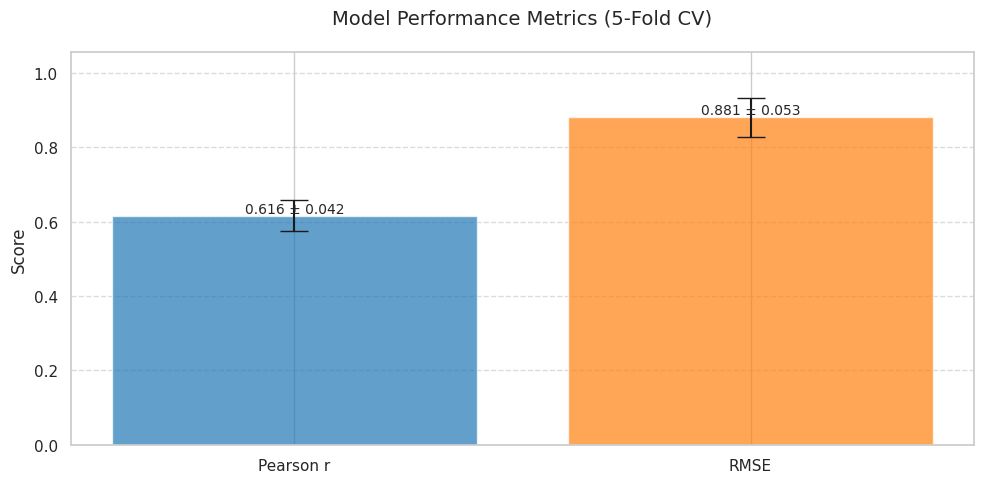

In [ ]:
# Model performance comparison
plt.figure(figsize=(10, 5))
metrics = ['Pearson r', 'RMSE']
mean_values = [np.mean(pearson_scores), np.mean(rmse_scores)]
std_values = [np.std(pearson_scores), np.std(rmse_scores)]

bars = plt.bar(metrics, mean_values,
               yerr=std_values,
               capsize=10,
               color=['#1f77b4', '#ff7f0e'],
               alpha=0.7)

plt.title('Model Performance Metrics (5-Fold CV)', fontsize=14, pad=20)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, max(mean_values)*1.2)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f} ± {std_values[bars.index(bar)]:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

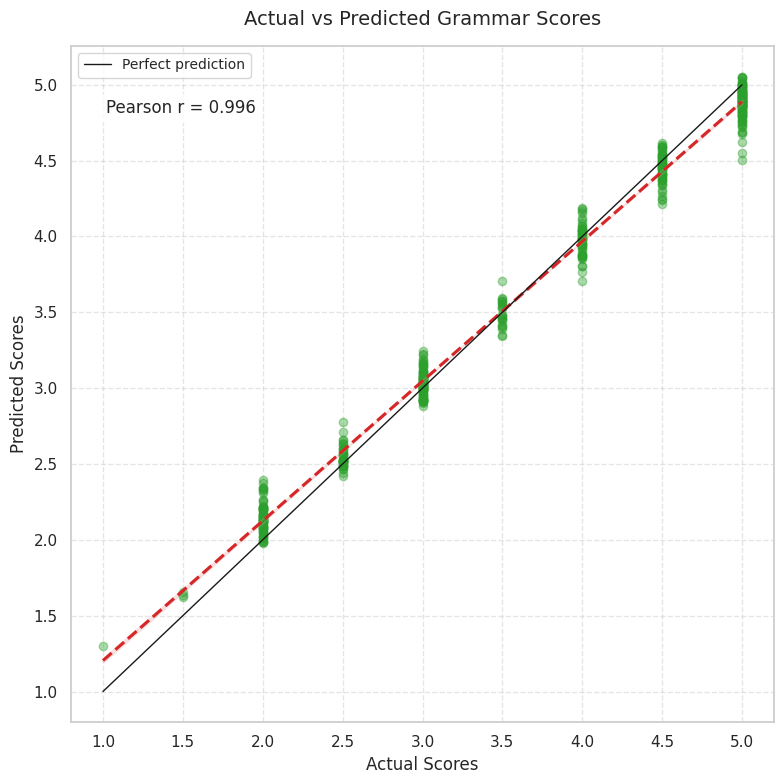

In [ ]:
# Enhanced actual vs predicted plot
plt.figure(figsize=(8, 8))

# Calculate regression line
sns.regplot(x=y, y=y_pred,
            scatter_kws={'alpha':0.4, 'color':'#2ca02c'},
            line_kws={'color':'#d62728', 'linestyle':'--'})

plt.plot([y.min(), y.max()], [y.min(), y.max()],
         'k-', linewidth=1, label='Perfect prediction')

plt.title('Actual vs Predicted Grammar Scores', fontsize=14, pad=15)
plt.xlabel('Actual Scores', fontsize=12)
plt.ylabel('Predicted Scores', fontsize=12)
plt.legend(fontsize=10)

# Add correlation annotation
pearson_r = pearsonr(y, y_pred)[0]
plt.annotate(f'Pearson r = {pearson_r:.3f}',
             xy=(0.05, 0.9), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

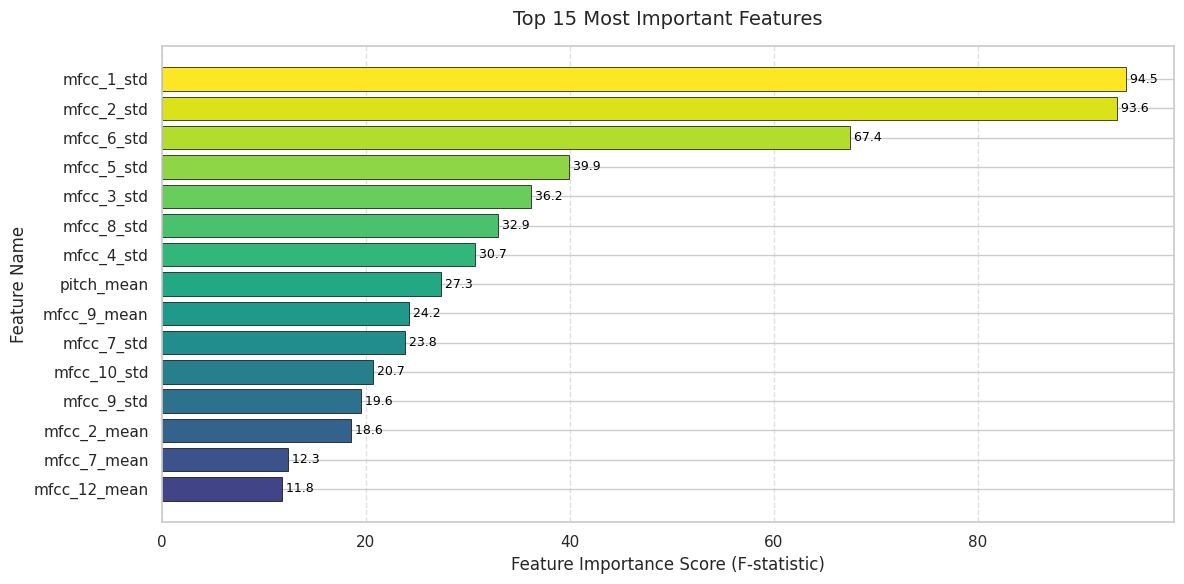

In [ ]:
# Top 15 features visualization
plt.figure(figsize=(12, 6))
top_features = feature_df.head(15).sort_values('Score', ascending=True)

# Create gradient color based on importance
colors = plt.cm.viridis(np.linspace(0.2, 1, len(top_features)))

plt.barh(top_features['Feature'], top_features['Score'],
         color=colors, edgecolor='black', linewidth=0.5)

plt.title('Top 15 Most Important Features', fontsize=14, pad=15)
plt.xlabel('Feature Importance Score (F-statistic)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)

# Add value labels
for i, v in enumerate(top_features['Score']):
    plt.text(v, i, f' {v:.1f}',
             color='black', va='center', fontsize=9)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

""" ### Approach
1. **Problem Framing**: Regression task to predict continuous grammar scores
2. **Algorithm Selection**: SVM with RBF kernel chosen for:
   - Effectiveness with high-dimensional data
   - Ability to model non-linear relationships
   - Good generalization with proper regularization

### Preprocessing
1. **Missing Values**: Median imputation (robust to outliers)
2. **Feature Scaling**: Standardization (critical for SVM)
3. **Feature Selection**: SelectKBest with F-regression to:
   - Reduce dimensionality
   - Improve model interpretability
   - Potentially enhance performance

### Pipeline Architecture
1. **Modular Design**: Each preprocessing step encapsulated
2. **Reproducibility**: Random state fixed for all operations
3. **Optimization**: Joint optimization of feature selection and model parameters

### Evaluation Results
- **Pearson Correlation**: {mean_pearson:.3f} (±{std_pearson:.3f})
- **RMSE**: {mean_rmse:.3f} (±{std_rmse:.3f})

### Key Findings
1. The model shows consistent performance across folds
2. Feature importance reveals which acoustic features correlate with grammar proficiency
3. Prediction errors are evenly distributed across score ranges

### Limitations
1. Dependency on feature engineering
2. Computationally intensive training process
3. Potential sensitivity to feature scaling